# Payout Patterns

In [1]:
from tmp import *

import networkx as nx
from networkx.algorithms import bipartite
from matplotlib import cm
import matplotlib.colorbar as cb
from matplotlib.colors import Normalize
from os import listdir
from os.path import isfile, join
import csv
from decimal import Decimal
from copy import copy

btccom_tag = 'BTC.com'
antpool_tag = 'AntPool'
viabtc_tag = 'ViaBTC'

flows_path = './dataset/flows_raw/'
base_path = flows_path + 'flow' # e.g., flow_address_1234


/home/matteo/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
## This cell might take some seconds

## Files generated with previous notebooks
with open('./dataset/blocks_attribution_0-556400.json', 'r') as fp:
    blocks = json.load(fp)    
with open('./dataset/miners_custom_color.json', 'r') as fp:
    miners = json.load(fp)

address_cluster = dict()
#sd# Export from Graphsense (only addresses found in coinbase flows)
with open('./dataset/address_cluster.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        address_cluster[row[0]] = row[1]

In [3]:
seed_addresses = dict() # key: addresses used for mining, value: miners for which address mined
for miner in miners:
    for addr in miners[miner]['addresses']:
        if addr not in seed_addresses:
            seed_addresses[addr] = ''
        seed_addresses[addr] += miner 

In [4]:
## Mapping addresses to clusters and to entities (tags)

def address2cluster(a):
    if a in address_cluster:
        return address_cluster[a]
    else:
        return a

def cluster2tag(cluster, exchanges_flag_needed=False, source_needed=False):
    source = ''
    res = 'None'
    cluster = str(cluster)
    is_exchange = False
    ## Try from seed file
    if cluster in additional_clusters_tags.keys():
        res = additional_clusters_tags[cluster]
        source = 'seed file'
    ## Try from graphsense
    elif cluster in cluster_tag.keys():
            res = cluster_tag[cluster]
            is_exchange = cluster_isExchange[cluster]
            source = 'graphsense'
    
    if res == 'None' and cluster in cluster_miners.keys() and cluster_miners[cluster] != 'unknown':
        res = cluster_miners[cluster] + '_cb' # cb stands for coinbase, to differentiate from official tags
    if exchanges_flag_needed:
        return limit_string(str(res), 30), is_exchange
    elif source_needed:
        return limit_string(str(res), 30), source
    else:
        return limit_string(str(res), 30)
    
def address2tag(address, exchanges_flag_needed=False):
    if exchanges_flag_needed:
        return cluster2tag(address2cluster(address), exchanges_flag_needed=exchanges_flag_needed)
    else:
        return cluster2tag(address2cluster(address), exchanges_flag_needed=exchanges_flag_needed)


In [5]:
## If seed addresses have clusters, we must link those clusters to the tags
## For example address 1KGbsDDAgJN2HDNBjmMHp9828qATo5B9c9 has a cluster, no graphsense cluster tag, but has a pool from the seeds
additional_clusters_tags = dict() # from seed addresses, clusterID as key, pool as value
for i, seed in enumerate(seed_addresses.keys()):
    additional_clusters_tags[address2cluster(seed)] = seed_addresses[seed]

In [6]:
## To get cluster tags from coinbase markers
## Read file if available, otherwise uncomment and run cell below
with open('./dataset/cluster_miners.json', 'r') as fp:
    cluster_miners = json.load(fp)

In [7]:
# cluster_miners = dict()
# for h in range(1, 514701):
#     miner = blocks[str(h)]['miner']
#     block_addresses = blocks[str(h)]['addresses']
#     for addr in block_addresses:
#         cluster = address2cluster(addr)
#         if len(cluster) < 33:
#             cluster = str(int(float(cluster)))
#         if cluster not in cluster_miners.keys():
#             cluster_miners[cluster] = set()
#         cluster_miners[cluster].add(miner)

# for k in cluster_miners.keys():
#     cluster_miners[k] = '_'.join(cluster_miners[k])
    
# with open('./dataset/cluster_miners.json', 'w') as fp:
#     json.dump(cluster_miners, fp)

In [8]:
## Mapping clusters to entities (tags)
df = pd.read_csv('./dataset/cluster_tags.csv', names=['cluster','tag','source','actor_category','source_uri'])
d = df.loc[df['source_uri'] == 'https://www.walletexplorer.com/'][['cluster', 'tag', 'actor_category']].to_dict('list')
cluster_tag = dict()
cluster_isExchange = dict()
for c,t in zip(d['cluster'], d['tag']):
    cluster_tag[str(c)] = t
for c,ac in zip(d['cluster'], d['actor_category']):
    if ac == 'Exchanges':
        cluster_isExchange[str(c)] = True
    else:
        cluster_isExchange[str(c)] = False

In [9]:
pools_heights = dict() # key: pool name, value: list of mined blocks
for h in blocks:
    m = blocks[h]['miner']
    if m not in pools_heights:
        pools_heights[m] = []
    pools_heights[m].append(int(h))
for pool in pools_heights:
    pools_heights[pool] = sorted(pools_heights[pool])

In [10]:
## Functions to get coinbase flows

def tree2step_dict(step_dict, tree, step, origin, use_cluster_ID=False, use_address_clusterID_tag=True, exchanges_flag_needed=True):
    exchange_found = False
    tag = 'None'
    for child in tree['children']:
        redeemed_tx = ''
        if 'redeemed_tx' in child.keys():
            redeemed_tx = child['redeemed_tx'][0]
        if 'name' in child.keys():
            node_name = child['name']
            if use_address_clusterID_tag:
                cluster_ID = address2cluster(node_name)
                tag, is_exchange = cluster2tag(cluster_ID, exchanges_flag_needed=exchanges_flag_needed)
                if is_exchange or exchange_found:
                    exchange_found = True
                node_name = node_name + '_' + cluster_ID + '_' + tag  
            if node_name not in step_dict.keys():
                step_dict[node_name] = []
            tx_info = dict()
            tx_info['received_BTC'] = child['value']
            tx_info['redeemed_tx'] = redeemed_tx
            tx_info['when'] = tree['time']
            tx_info['from'] = origin
            step_dict[node_name].append(tx_info)
            node_name = node_name + '_' + str(step + 1)
            prev_node_name = tx_info['from'] + '_' + str(step)
    if exchanges_flag_needed:
        return step_dict, exchange_found
    return step_dict

def do_steps(steps_list, step, max_steps, use_cluster_ID=True, nodes_limit=100, exchange_found=False):
    ## recursive function
    ## nodes_limit is to avoid scraping tons of transactions when max_steps is too large
    if step <= max_steps and len(steps_list[step-1].keys()) < nodes_limit and not exchange_found:
        step_dict = dict() # addresses as keys, list of [BTC, redeemed_tx] as value
        for node_name in steps_list[step-1].keys():
            ## see how it spent BTC
            for tx in steps_list[step-1][node_name]: # an addr or cluster can receive BTC multiple times from different addresses of the previous level
                tx_index = tx['redeemed_tx']
                if tx_index:
                    tree_url = 'https://blockchain.info/tree/' + str(tx_index) + '?format=json'
                    tree = url2dict(tree_url)
                    ## for each spent output get indeces of next level
                    step_dict, exchange_flag = tree2step_dict(step_dict, tree, step, node_name, use_cluster_ID=use_cluster_ID, exchanges_flag_needed=True)
                    if exchange_flag or exchange_found:
                        exchange_found = True
        ## at least one redeemed_tx is needed to do another step
        if step_dict:
            steps_list.append(step_dict)
            success = False
            while not success:
                try:
                    return do_steps(steps_list, step+1, max_steps, use_cluster_ID, exchange_found=exchange_found)
                    success = True
                except Exception as e:
                    print_error_and_sleep(e, 5)
        else:
            return steps_list
    else:
        return steps_list

def save_coinbase_flow(steps_list, h, use_cluster_ID=False):
    file_path = base_path + '_' + str(h) + '.json'
    with open(file_path, 'w') as fp:
        json.dump(steps_list, fp)
        
def continue_coinbase_flow(height, use_cluster_ID, max_steps):
    file_path = base_path + '_' + str(height) + '.json'
    with open(file_path, 'r') as fp:
        steps_list = json.load(fp)
    initial_len = len(steps_list)
    if initial_len-1 < max_steps:
        success = False
        while not success:
            try:
                steps_list = do_steps(steps_list, initial_len, max_steps, use_cluster_ID)
                success = True
            except Exception as e:
                print_error_and_sleep(e, 5)
        save_coinbase_flow(steps_list, height, use_cluster_ID)
        return steps_list
    else:
        return steps_list[:max_steps]

def get_coinbase_flow(height, max_steps=0, use_cluster_ID=False):
    ## Params:
    ## height: int specifying the block height 
    ## max_steps: int specifying the number of steps from the coinbase, if 0 we try to use all the already available steps
    ## use_cluster_ID: False to see coinbase flowing through addresses, True for clusters
    
    ## Outputs:
    ## steps_list: list with a tree-like structure, each element is a dict representing a step 
    
    if max_steps:
        ## we get all the steps till max_steps, resuming from file or starting from scratch
        try:
            ## check if the flow is already available
            return continue_coinbase_flow(height=height, use_cluster_ID=use_cluster_ID, max_steps=max_steps)
        except:
            ## start from scratch
            success = False
#             while not success:
#                 try:
            block_hash = blocks[str(height)]['hash']
            block = bx.get_block(block_hash)
            tx_index = block.transactions[0].tx_index
            success = True
#                 except Exception as e:
#                     print(e)
#                     sleep(.1)
            tree_url = 'https://blockchain.info/tree/' + str(tx_index) + '?format=json'
            tree = url2dict(tree_url)
            step_dict = dict() # addresses as keys, list of [BTC, redeemed_tx] as value
            steps_list = [] # steps_list[i] for step i, each element is a step_dict

            node_name = str(height) + '_0' # step 0
            ## for each spent output get indeces of next level
            step_dict, exchange_found = tree2step_dict(step_dict, tree, 0, str(height), use_cluster_ID) # step from coinbase to output addresses
            steps_list.append(step_dict)

            success = False
            while not success:
                try:
                    steps_list = do_steps(steps_list, 1, max_steps, use_cluster_ID, exchange_found=exchange_found)
                    success = True
                except Exception as e:
                    print_error_and_sleep(e, 5)
            save_coinbase_flow(steps_list, height, use_cluster_ID)
            return steps_list
    else:
        ## we just get the steps we have
        ## if we fail, is because the file does not exist and we must specify max_steps 
        file_path = base_path + '_' +  str(height) + '.json'
        with open(file_path, 'r') as fp:
            steps_list = json.load(fp)
        return steps_list


In [11]:
def get_num_clusters_in_pool_flows(pool, descending=True, addresses=False):
    ## make sure you already have the coinbase flows for the pool
    ## for a given pool returns a dict with height as key, list of num_clusters per step as value
    ## addresses: True to get the number of addresses instead of clusters
    
    l = dict() # height as key, list of num_clusters per step as value
    ordered_heights = pools_heights[pool] # ascending
    if descending:
        ordered_heights = pools_heights[pool][::-1]
    for h in ordered_heights:
        print(h, end='\r')
        try:
            flow = get_coinbase_flow(h) 
            current = []
            for step in range(len(flow)):
                clusters_in_step = set()
                for act in flow[step].keys():
                    if addresses:
                        clusters_in_step.add(act.split('_')[0])
                    else:
                        clusters_in_step.add(address2cluster(act.split('_')[0]))
                current.append(len(clusters_in_step))# number of addresses in limit flow
            l[h] = current
        except Exception as e:
            print(e)
    return l

# Read files if available, otherwise run cell afterwards

In [12]:
with open('./dataset/all_pools_n_clusters.json', 'r') as fp:
    all_pools_n_clusters = json.load(fp)

with open('./dataset/all_pools_n_addresses.json', 'r') as fp:
    all_pools_n_addresses = json.load(fp)


In [91]:
## WARNING: this cell might take some minutes
# all_pools_n_addresses = dict()
# for pool in ['AntPool', 'BTC.com', 'ViaBTC']:
#     t = time()
#     print(pool)
#     all_pools_n_addresses[pool] = get_num_clusters_in_pool_flows(pool, addresses=True)
#     print(time() - t)

# Payout trends
Plots to see how many addresses/clusters we have in each coinbase flow

BTC.com


/home/matteo/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


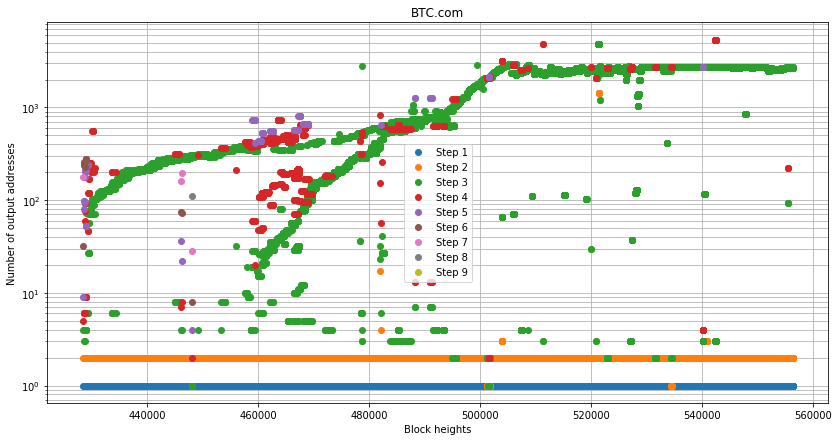

AntPool


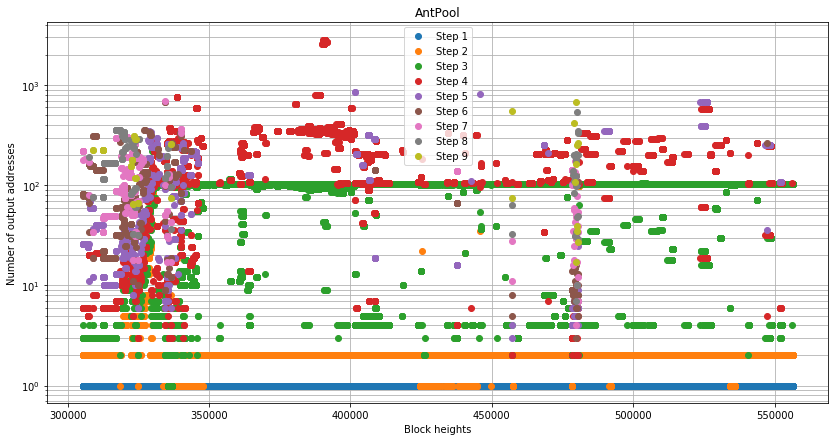

ViaBTC


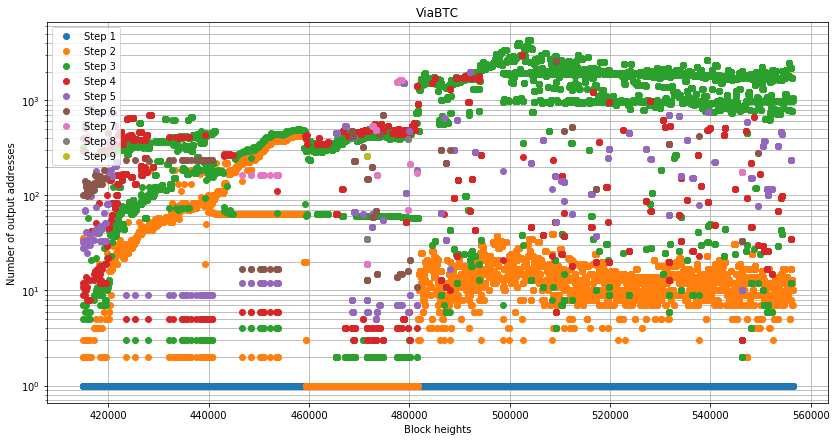

In [12]:
## ADDRESS DATASET
pool_payout_trends = dict() # pool as key, trend as value
for pool in ['BTC.com', 'AntPool', 'ViaBTC']:
    pool_payout_trends[pool] = []
    print(pool)
    ordered = list(all_pools_n_addresses[pool].keys()) # mined blocks from pool
    ordered.sort()
    last = []
    i = 0
    n_steps = 10 # at most
    for h in ordered:
        if int(h) > 200000:
            current = all_pools_n_addresses[pool][h] # 
            if len(current) >= n_steps:
                to_append = [h] + current
            else:
                to_append = [h] + current + [0 for i in range(n_steps-len(current))]
            pool_payout_trends[pool].append(to_append)
    steps = [] # steps[s] is the number of output clusters at step s
    for step in range(n_steps):
        steps.append([pool_payout_trends[pool][i][step] for i in range(len(pool_payout_trends[pool]))])
    plt.figure(figsize=(14,7))
    for s in range(1, n_steps):
        plt.semilogy([int(el) for el in steps[0]], steps[s], 'o', label='Step ' + str(s))
    plt.grid(True, which='both')
    plt.legend()
    plt.ylabel('Number of output addresses')
    plt.xlabel('Block heights')
    plt.title(pool.split(' ')[-1])
    plt.show()

BTC.com


/home/matteo/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


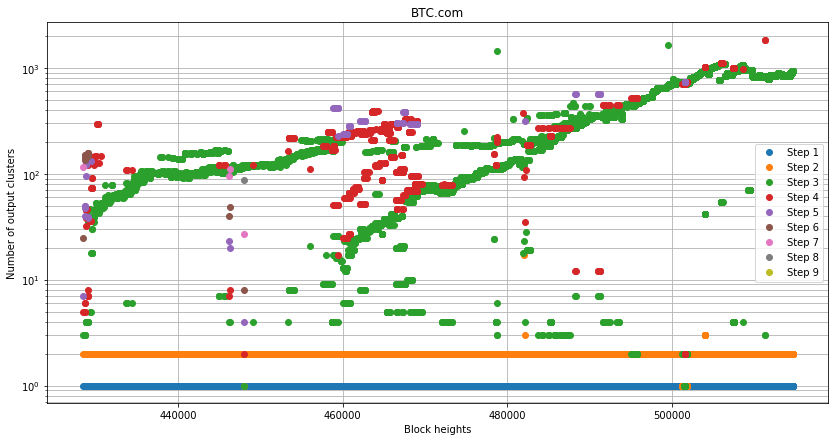

AntPool


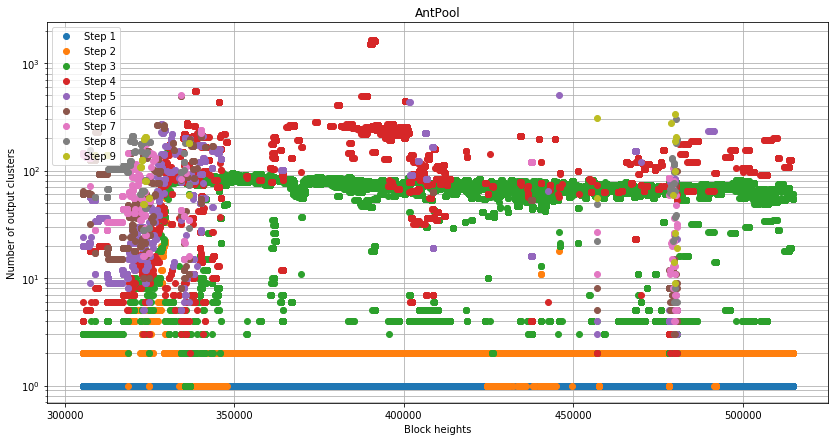

ViaBTC


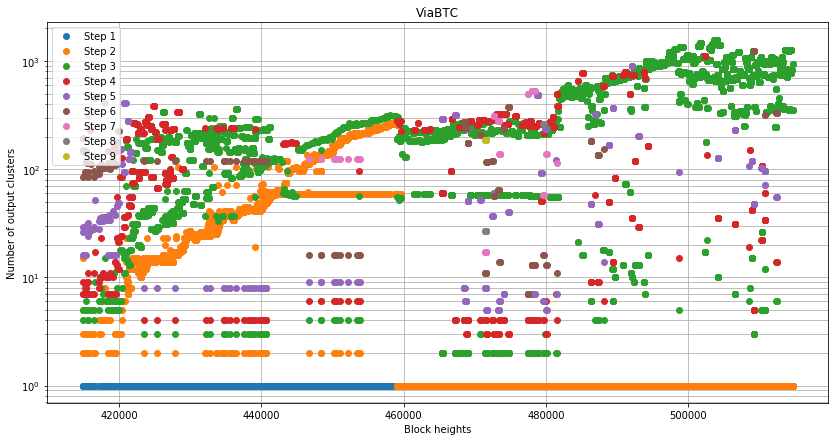

In [13]:
## CLUSTER DATASET
pool_payout_trends = dict() # pool as key, trend as value
for pool in ['BTC.com', 'AntPool', 'ViaBTC']:
    pool_payout_trends[pool] = []
    print(pool)
    ordered = list(all_pools_n_clusters[pool].keys()) # mined blocks from pool
    ordered.sort()
    last = []
    i = 0
    n_steps = 10 # at most
    for h in ordered:
        if int(h) > 200000:
            current = all_pools_n_clusters[pool][h] # 
            if len(current) >= n_steps:
                to_append = [h] + current
            else:
                to_append = [h] + current + [0 for i in range(n_steps-len(current))]
            pool_payout_trends[pool].append(to_append)
    steps = [] # steps[s] is the number of output clusters at step s
    for step in range(n_steps):
        steps.append([pool_payout_trends[pool][i][step] for i in range(len(pool_payout_trends[pool]))])
    plt.figure(figsize=(14,7))
    for s in range(1, n_steps):
        plt.semilogy([int(el) for el in steps[0]], steps[s], 'o', label='Step ' + str(s))
    plt.grid(True, which='both')
    plt.legend()
    plt.ylabel('Number of output clusters')
    plt.xlabel('Block heights')
    plt.title(pool.split(' ')[-1])
    plt.show()

In [13]:
## Functions to retrieve pools' members

def get_all_sent_txs_by_address(address):
    empty = False
    all_txs = []
    offset = 0
    while not empty:
        fifty_txs = get_address_sent_txs(address, offset=offset)
        if len(fifty_txs):
            for tx in fifty_txs:
                all_txs.append(tx)
        else:
            empty = True
        offset += 1
    return all_txs

def get_all_received_txs_by_address(address):
    empty = False
    all_txs = []
    offset = 0
    while not empty:
        fifty_txs = get_address_reveived_txs(address, offset=offset)
        if len(fifty_txs):
            for tx in fifty_txs:
                all_txs.append(tx)
        else:
            empty = True
        offset += 1
    return all_txs

def is_payout_tx(tx, BTC_threshold=10, exact_number=0, threshold_down=30, threshold_up=0, med=2, members=None, members_treshold=3, typ=None):
    res = False
    n_outputs = 0
    values = []
    if typ == 'blockchain_info_tree':
        for out in tx['children']:
            n_outputs += 1
            values.append(out['value'])
    else:
        for out in tx['out']:
            n_outputs += 1
            values.append(out['value']/10**8)
    median = np.median(values)
    if median < med:
        if exact_number:
            if n_outputs == exact_number:
                return True
            else:
                return False
        elif n_outputs > threshold_down:
            if threshold_up and n_outputs < threshold_up:
                res = True
            if not threshold_up:
                res = True
    return res

def get_dataframe(member_BTC_list, pool_name, pool_addresses=None):
    outputs_df = pd.DataFrame({'address':[el[0] for el in member_BTC_list], pool_name + '_' +'BTC_address':[el[1] for el in member_BTC_list]})
    outputs_df['cluster'] = outputs_df.apply(lambda row: address2cluster(row.address), axis=1)
    outputs_df['tag'] = outputs_df.apply(lambda row: address2tag(row.address), axis=1)
    members_df = outputs_df
    if pool_addresses:
        members_df = outputs_df.loc[outputs_df['address'].isin(pool_addresses) == False]

    paid_BTC = sum(members_df[[pool_name + '_' + 'BTC_address']].values)[0]
    cluster_BTC_df = members_df.groupby('cluster').sum().reset_index()\
        .sort_values(pool_name + '_' +'BTC_address', ascending=False).rename(index=str, columns={pool_name + '_' +'BTC_address': pool_name + '_' +'BTC_cluster'})
    tag_BTC_df = members_df.groupby('tag').sum().reset_index()\
        .sort_values(pool_name + '_' +'BTC_address', ascending=False).rename(index=str, columns={pool_name + '_' +'BTC_address': pool_name + '_' +'BTC_tag'})
    address_cluster_df = cluster_BTC_df.merge(members_df, on='cluster')
    address_cluster_tag_df = address_cluster_df.merge(tag_BTC_df, on='tag')
    cluster_addr = members_df.groupby('cluster').count().reset_index()[['cluster', 'address']].rename(index=str, columns={'address': 'n_cluster_addresses'})
    tag_addr = members_df.groupby('tag').count().reset_index()[['tag', 'address']].rename(index=str, columns={'address': 'n_tag_addresses'})
    complete_df = address_cluster_tag_df.merge(cluster_addr, on='cluster')
    complete_df = complete_df.merge(tag_addr, on='tag')
    complete_df[pool_name + '_' +'cluster_perc'] = complete_df.apply(lambda x: 100*x[pool_name + '_' + 'BTC_cluster']/paid_BTC, axis=1)
    complete_df[pool_name + '_' +'tag_perc'] = complete_df.apply(lambda x: 100*x[pool_name + '_' + 'BTC_tag']/paid_BTC, axis=1)
    complete_df[pool_name + '_' +'address_perc'] = complete_df.apply(lambda x: 100*x[pool_name + '_' + 'BTC_address']/paid_BTC, axis=1)
    return complete_df

def find_richest_address(tx, pos=1):    
    data = []
    for n_out,out in enumerate(tx['out']):
        if 'addr' in out.keys():
            data.append([out['addr'], out['value']/10**8])
    data.sort(key=lambda t: -t[1])
    if pos == 1:
        return data[0][0]
    if pos == 2:
        return data[0][0], data[1][0]

def tx_index2dict(tx_index):
    tree_url = 'https://blockchain.info/tree/' + str(tx_index) + '?format=json'
    tree = url2dict(tree_url)
    return tree

def find_richest_addresses(tx, n=1):
    data = []
    tx_index = 0
    if 'out' in tx.keys():
        for n_out,out in enumerate(tx['out']):
            if 'addr' in out.keys():
                if 'tx_index' in out.keys(): # if it has been spent
                    tx_index = out['tx_index'] # to traverse the tree
                data.append([out['addr'], out['value']/10**8, tx_index])
    else:
        for n_out,out in enumerate(tx['children']):
            if 'redeemed_tx' in out.keys(): # if it has been spent
                tx_index = out['redeemed_tx'][0] # to traverse the tree, (there could be more than one tx_index, currently selecting only one)
                data.append([out['name'], out['value'], tx_index])

    data.sort(key=lambda t: -t[1])
    return data[:n]
   
def add_members(tx, members, senders=None, typ=None):
    if typ == 'blockchain_info_tree':
        # no need to add sender here, it is added in check_tx_and_add_members
        for n_out,out in enumerate(tx['children']):
            if 'name' in out.keys():
                if out['name'] not in members.keys():
                    members[out['name']] = []
                btc = out['value']
                members[out['name']].append([btc, tx['time']])
    else:
        if senders:
            for inp in tx['inputs']:
                senders.add(inp['prev_out']['addr'])
        for n_out,out in enumerate(tx['out']):
            if out['addr'] not in members.keys():
                members[out['addr']] = []
            btc = out['value']/10**8
            members[out['addr']].append([btc, tx['time']])
    return members, senders
    
def get_members(po_txs):
    members = dict()
    senders = set()
    for n, hsh in enumerate(po_txs):
        print(n, end='\r')
        members, senders = add_members(get_tx(hsh), members, senders)
    for s in senders:
        if s in members.keys():
            del members[s]
    return members

def check_tx_and_add_members(start_time, end_time, member, txs_considered, tx, sender, senders, po_txs):
    # add members if tx satisfies rules
    found = False
    if 'hash' not in tx.keys():
        # no hash because coming from blockchain.info internal tree
        # check time period and add members
        if tx['time'] > start_time and tx['time'] < end_time + secs_in_day:
            if is_payout_tx(tx, typ='blockchain_info_tree', exact_number=101):
                # add members
                member, senders = add_members(tx, member, senders=senders, typ='blockchain_info_tree')
                senders.add(sender)
                po_txs.add(tx['tx_index'])
                found = True
                
    elif tx['time'] not in txs_considered:
        txs_considered.add(tx['time'])
        # check time period and add members
        if tx['time'] > start_time and tx['time'] < end_time + secs_in_day:
            if is_payout_tx(tx, exact_number=101):
                # add members
                po_txs.add(tx['hash'])
                member, senders = add_members(tx, member, senders=senders)
                senders.add(sender)
                found = True
    return member, txs_considered, found, senders, po_txs
    
def explore_chain(start_time, end_time, member, txs_considered, tx, max_n_richest_addresses, max_steps, step, sender, senders, po_txs):
    step += 1
    member, txs_considered, found, senders, po_txs = check_tx_and_add_members(start_time, end_time, member, txs_considered, tx, sender, senders, po_txs)
    if found and step < max_steps:
        # get richest addresses
        richest_addresses = find_richest_addresses(tx, n=max_n_richest_addresses)
        for r,rich in enumerate(richest_addresses):
            # get tx where btc was spent
            if rich[2]: # if tx_index, then it has been spent, how?
                tx = tx_index2dict(rich[2])
                # if this is a po tx, remove the address from member
                # explore chain recursively
                member, txs_considered, senders, po_tx = explore_chain(start_time, end_time, member, txs_considered, tx, max_n_richest_addresses, max_steps, step, rich[0], senders, po_txs)
            else:
                return member, txs_considered, senders, po_txs
    return member, txs_considered, senders, po_txs
    

# Retrieve members of pools
# BTC.com
collected all txs of 3EKc1EHHRVJrwBGFgvxd7ZJrKxjTHZZFhV, known to be an address used by the pool for payout txs, chosen only payout txs happening between 510000 and 2016 * 2 blocks afterwards. I save then for each output address the amount received and the timestamp of each payment.

# AntPool
get all payout tx of address 1F4JZYZr4rQhFeJ9P4N9ZL2cHe5cPsbnxw,
save all output addresses in members,
get all sent txs of richest address,
if it performed a payout tx, add it to change addresses,
remove all change addresses at the end

what if a change address is not a richest address? => check second/third richest address
increase steps or stop exploring chain

# ViaBTC
only one payout address, got all its txs, saved addresses receiving 10 btc, got all their txs and used all their payout txs to get members, some richest addresses are also change addresses and are removed by checking their payout transactions


In [96]:
## # Read files if available, otherwise run cells below
with open('./dataset/viabtc_members.json', 'r') as fp:
    viabtc_member_BTC_list = json.load(fp)
with open('./dataset/viabtc_members_dict.json', 'r') as fp:
    viabtc_member_BTC_dict = json.load(fp)
with open('./dataset/btc_com_members_550000_554032.json', 'r') as fp:
    btccom_member_BTC_list2 = json.load(fp)
with open('./dataset/btc_com_members_dict_550000_554032.json', 'r') as fp:
    btccom_member_BTC_dict2 = json.load(fp)
with open('./dataset/btc_com_members.json', 'r') as fp:
    btccom_member_BTC_list = json.load(fp)
with open('./dataset/btc_com_members_dict.json', 'r') as fp:
    btccom_member_BTC_dict = json.load(fp)
with open('./dataset/antpool_members.json', 'r') as fp:
    antpool_member_BTC_list = json.load(fp)
with open('./dataset/antpool_members_dict.json', 'r') as fp:
    antpool_member_BTC_dict = json.load(fp)

pool_addresses = set(['3EKc1EHHRVJrwBGFgvxd7ZJrKxjTHZZFhV', '18AR7ptjQxHfDrrGh1SKgv1jyFDNjJkaWw'])

btccom_df = get_dataframe(btccom_member_BTC_list, pool_name='BTC.com', pool_addresses=pool_addresses)
btccom_df2 = get_dataframe(btccom_member_BTC_list2, pool_name='BTC.com')
antpool_df = get_dataframe(antpool_member_BTC_list, pool_name='AntPool')
viabtc_df = get_dataframe(viabtc_member_BTC_list, pool_name='ViaBTC')

### BTC.com

In [14]:
## WARNING: this cell might take some seconds/minutes

pool = 'BTC.com'
start_height = 510000
n_blocks = 2016*2
end_height = start_height + n_blocks
start_time = blocks[str(start_height)]['time']
end_time = blocks[str(end_height)]['time']
possible_senders = set() # addresses that might perform payout transactions, either first or second level
# possible_senders.add('18AR7ptjQxHfDrrGh1SKgv1jyFDNjJkaWw') # collector address?
possible_senders.add('3EKc1EHHRVJrwBGFgvxd7ZJrKxjTHZZFhV') # known collector address

btccom_po_tx = set() # payout transactions

member = dict()
txs_considered = set() # already analyzed
rounds = 1 # how many times we update possible_senders, like steps in flows, if greater than 2, we get a lot of addresses to check
for i in range(rounds):
    print('Initial possible senders to analyze:', len(possible_senders))
    for possible_sender in possible_senders:
        all_txs = get_all_sent_txs_by_address(possible_sender)
        print('Number of possible payout transactions', len(all_txs))
        for it, tx in enumerate(all_txs):
            print(it, end='\r')
            if tx['hash'] not in txs_considered:
                txs_considered.add(tx['hash'])
                if is_payout_tx(tx): # yes, rule of thumb
                    if tx['time'] > start_time and tx['time'] < end_time + secs_in_day:
                        member, _ = add_members(tx, member)
                        btccom_po_tx.add(tx['hash'])
    

Initial possible senders to analyze: 1
Number of possible payout transactions 1092


In [15]:
len(btccom_po_tx)

225

In [16]:
member_BTC_list = []
for m, BTC_time in member.items():
    member_BTC_list.append([m, sum([el[0] for el in BTC_time])])
member_BTC_list.sort(key=lambda x: -x[1])

In [17]:
with open('./dataset/btc_com_members.json', 'w') as fp:
    json.dump(member_BTC_list, fp)
with open('./dataset/btc_com_members_dict.json', 'w') as fp:
    json.dump(member, fp)
    
## For the second period analyzed
# with open('./dataset/btc_com_members_550000_554032.json', 'w') as fp:
#     json.dump(member_BTC_list, fp)
# with open('./dataset/btc_com_members_dict_550000_554032.json', 'w') as fp:
#     json.dump(member, fp)

### AntPool

In [59]:
## WARNING: this cell might take some seconds

## get all po tx from 1F4JZYZr4rQhFeJ9P4N9ZL2cHe5cPsbnxw and store addresses (clusters better)
pool = 'AntPool'
start_height = 510000
n_blocks = 2016*2
end_height = start_height + n_blocks
start_time = blocks[str(start_height)]['time']
end_time = blocks[str(end_height)]['time']

antpool_po_txs = set() # for some po txs, only the tx_index from blockchain.info will be available 

root = '1F4JZYZr4rQhFeJ9P4N9ZL2cHe5cPsbnxw' # known collector address
all_txs = get_all_sent_txs_by_address(root)
sets = dict()
for max_n_richest_addresses in [1]:
    for max_steps in [30]:
        key = str(max_steps) + '_' + str(max_n_richest_addresses)        
        t0 = time()
        step = 0
        senders = set()
        senders.add(root)
        member = dict()
        txs_considered = set()
        print(len(all_txs))
        for i,tx in enumerate(all_txs):
            print(i, end='\r')
            member, txs_considered, senders, antpool_po_txs = explore_chain(start_time, end_time, member, txs_considered, tx, max_n_richest_addresses, max_steps, step, root, senders, antpool_po_txs)
        for sender in senders:
            member.pop(sender, None)
        sets[key] = set(member.keys())
        print('max_steps', max_steps, 'max_n_richest_addresses', max_n_richest_addresses, 'time', time()-t0, 'number of members', len(member))

594
max_steps 30 max_n_richest_addresses 1 time 16.281338930130005 number of members 9366


In [60]:
member_BTC_list = []
for m, BTC_time in member.items():
    member_BTC_list.append([m, sum([el[0] for el in BTC_time])])
member_BTC_list.sort(key=lambda x: -x[1])

In [61]:
member_BTC_list[:15]

[['1A8Mx2BxCuUfBCz52jkpVsvPEiYTKSCisW', 997.15839399],
 ['1D8ZAXUum6CTcYMVVcskjeBnq5mpeJcG1W', 988.74994142],
 ['1BHRvGNY8oee4554nePgwiPPjjtAXvLp3w', 909.28763479],
 ['1G6XL4RZ1qZstmZBzVAwuuGyHeGLgseXuh', 905.62573665],
 ['15qnxbMHB9bhwYcCpstaQuUSuiJXECnEvx', 856.35559917],
 ['12y5D4rUr39i82n9ZXNZQ1Vbe13Wiw7U4Q', 826.31524607],
 ['1QDompwnUuh9tYsat24bXYTBrpsgbpoXXD', 501.33849419],
 ['1LXsfvjJ6CeNTMizHptgseuYXTuLQhhRXU', 352.60672123],
 ['16peVP3fXJK4dWfEjTi8RNs7HrhSUzEYvG', 42.26075286],
 ['1A9dTFkkz9w3wzBSuh2xjmuzjBrgkF36k2', 30.2624574],
 ['1F6TWBfJhGMQitwuEWTJwBtm9nqjHD1RLt', 24.65581805],
 ['178WqNh4Fx7dKERw7xbxzwuciejeYE1qj1', 23.169761259999998],
 ['14pF6frsf1E7Eh2gmqc7PDoDVLKU8uFC9n', 20.490597579999996],
 ['1HeDy6E4pBfdwqUJ7wD9ytbdzjGTeaygf8', 19.89603618],
 ['1MsfGQ8BpLw1i3wnTsCxE1iYSVbSBCWqyR', 18.34186861]]

In [62]:
## by looking at each address' activity
not_members = ['1MwqAe7Er7SL4pYNntLjirGrnwLaH2w6x5', 
               '1BFp1AEtGMRPwJG2Cc7veQriTWE56W2gVh', 
               '19gay3r4WcG53Za7aWfuq6U3bm1WbJ14gq', 
               '16sfdHncUk8G2ZiUj8VKHaDeQ96grW8pFE', 
               '1H4gKyHdcB1NVipjUtFBFNmqc1dp5HWCb3', 
               '1GKY9wPWYsJp1M1yiJTcrpPxZCm9RtRo95', 
               '1GdTHCBq7jgos8VMNrNNzugHhdDrSCMF2E', 
               '1JnfVeF1wRAtrdBg9SXckj5Z1uk6EDS5rd', 
               '1Q8M1Ld4sgGd41fmUyVveW6BUMWKgpy8Ht', 
               '11bEZQBQkR6KsPoh3Phbznsa88j3teEAs', 
               '13GH8s6Gaj7KG4ihrtFfTZZJK3M3UkAfRy', 
               '1A8Mx2BxCuUfBCz52jkpVsvPEiYTKSCisW', 
               '1D8ZAXUum6CTcYMVVcskjeBnq5mpeJcG1W', 
               '1BHRvGNY8oee4554nePgwiPPjjtAXvLp3w', 
               '1G6XL4RZ1qZstmZBzVAwuuGyHeGLgseXuh',
               '15qnxbMHB9bhwYcCpstaQuUSuiJXECnEvx',
               '12y5D4rUr39i82n9ZXNZQ1Vbe13Wiw7U4Q',
               '1QDompwnUuh9tYsat24bXYTBrpsgbpoXXD',
               '1LXsfvjJ6CeNTMizHptgseuYXTuLQhhRXU',
              ]

In [63]:
more_possible_senders = set()
for m in [el[0] for el in member_BTC_list[:8]]:
    ats = get_all_sent_txs_by_address(m)
    to_remove = False
    for tx in ats:
        if tx['time'] > start_time and tx['time'] < end_time + secs_in_day:
            if is_payout_tx(tx, exact_number=101):
                antpool_po_txs.add(tx['hash'])
                to_remove = True
    if to_remove:
        more_possible_senders.add(m)


In [64]:
len(antpool_po_txs)

186

In [93]:
## before running this cell, make sure to check the possible senders to really be senders
for sender in more_possible_senders:
    member.pop(sender, None)
    
for nm in not_members:
    member.pop(nm, None)

member_BTC_list = []
for m, BTC_time in member.items():
    member_BTC_list.append([m, sum([el[0] for el in BTC_time])])
member_BTC_list.sort(key=lambda x: -x[1])

In [95]:
with open('./dataset/antpool_members.json', 'w') as fp:
    json.dump(member_BTC_list, fp)
with open('./dataset/antpool_members_dict.json', 'w') as fp:
    json.dump(member, fp)

### ViaBTC

In [26]:
## WARNING: this cell might take some seconds

## get all payout addresses after start_height and end_height
start_height = 510000
n_blocks = 2016*2
end_height = start_height + n_blocks
start_time = blocks[str(start_height)]['time']
end_time = blocks[str(end_height)]['time']

po_addresses = set()
lst = [h for h in pools_heights['ViaBTC'] if h > start_height and h < end_height]
for e,b in enumerate(lst):
    flow = get_coinbase_flow(b, max_steps=3)
    for k in flow[0].keys():
        po_addresses.add(k.split('_')[0])

In [27]:
## get their outgoing txs and the possible senders (payout addresses=addresses performing payout transactions)
txs_considered = set()
possible_senders = set() # addresses receiving 10
for addr in po_addresses:
    all_txs = get_all_sent_txs_by_address(addr)
    # save addresses receiving 10 and get their po txs
    for tx in all_txs:
        for out in tx['out']:
            if 'addr' in out.keys():
                if out['value']/10**8 == 10:
                    possible_senders.add(out['addr']) 


In [28]:
## WARNING: this cell might take some minutes

## get pool members from po txs of senders (10 btc receivers)
viabtc_po_tx = set()
member = dict()
for i, sender in enumerate(list(possible_senders)):
    at_least_one_po_tx = False
    print(i, len(possible_senders), end='\r')
    all_txs_sender = get_all_sent_txs_by_address(sender)
    for tx in all_txs_sender:
        if tx['hash'] not in txs_considered:
            txs_considered.add(tx['hash'])
            if is_payout_tx(tx):
                at_least_one_po_tx = True
                if tx['time'] > start_time and tx['time'] < end_time + secs_in_day:
                    member, _ = add_members(tx, member)
                    viabtc_po_tx.add(tx['hash'])

https://blockchain.info/address/1BJdukeC6ANTbSubsYkmeVRdH2kUdsvFpk?format=json&offset=50&limit=50&sort=0&filter=1
https://blockchain.info/address/1BJdukeC6ANTbSubsYkmeVRdH2kUdsvFpk?format=json&offset=50&limit=50&sort=0&filter=1
<class 'TypeError'> tmp.py 332


In [29]:
for sender in possible_senders:
    member.pop(sender, None) # they are not senders but still pool addresses

In [30]:
member_BTC_list = []
for m, BTC_time in member.items():
    member_BTC_list.append([m, sum([el[0] for el in BTC_time])])
member_BTC_list.sort(key=lambda x: -x[1])

In [31]:
with open('./dataset/viabtc_members.json', 'w') as fp:
    json.dump(member_BTC_list, fp)
with open('./dataset/viabtc_members_dict.json', 'w') as fp:
    json.dump(member, fp)

# Table 3

### Number of blocks mined between 510000 and 514032

In [97]:
for pool in ['BTC.com', 'AntPool', 'ViaBTC']:
    n = 0
    for h in pools_heights[pool]:
        h = int(h)
        if h >= start_height and h <= end_height:
            n += 1
    print(pool, end_height, n)

BTC.com 514032 1020
AntPool 514032 617
ViaBTC 514032 455


ViaBTC mined 457 blocks actually, 2 of them have a conflict with okminer (just software, not a pool)

### Number of payout transactions

In [98]:
len(btccom_po_tx)

225

In [99]:
len(antpool_po_txs) # why different from paper???

186

In [100]:
len(viabtc_po_tx)

104

### Number of pool members

In [101]:
len(btccom_member_BTC_dict)

20444

In [102]:
len(antpool_member_BTC_dict) # different from paper

9358

In [103]:
len(viabtc_member_BTC_dict)

7171

### Number of clusters
Numbers can be lower from paper due to new txs joining clusters together, but why are some numbers higher than in the paper??? Possible reasons:

1. more coinjoins have been ignored after recomputing the clustering
2. the new address_cluster.csv does not contain some addresses that actually belong to a cluster (waiting for Aljosha to increase memory)

In [104]:
len(btccom_df.cluster.unique()) 

10083

In [105]:
len(antpool_df.cluster.unique())

5741

In [106]:
len(viabtc_df.cluster.unique())

2962

### BTC mined

In [107]:
pool_revenue = dict()
pool_revenue[btccom_tag] = 0
pool_revenue[antpool_tag] = 0
pool_revenue[viabtc_tag] = 0
for h in range(start_height, end_height):
    if blocks[str(h)]['miner'] in [btccom_tag, antpool_tag, viabtc_tag]:
        pool_revenue[blocks[str(h)]['miner']] += int(blocks[str(h)]['payout'])

In [108]:
for k in pool_revenue:
    print(k, round(pool_revenue[k]/1e8, 2))

BTC.com 13058.69
AntPool 7887.13
ViaBTC 5815.8


### BTC paid
Why are these numbers different from the paper? 

In [109]:
btccom_df[['BTC.com_BTC_address']].sum().values[0]

12056.7955845

In [110]:
antpool_df[['AntPool_BTC_address']].sum().values[0]

1074.75063136

In [111]:
viabtc_df[['ViaBTC_BTC_address']].sum().values[0]

4282.903891849999

### Median address reuse

In [112]:
lst = [len(btccom_member_BTC_dict[k]) for k in btccom_member_BTC_dict.keys()]
print('Median', np.median(lst))
print('Normalized Median {:.2e}'.format(Decimal(np.median(lst)/len(btccom_member_BTC_dict))))

Median 20.0
Normalized Median 9.78e-4


In [113]:
lst = [len(antpool_member_BTC_dict[k]) for k in antpool_member_BTC_dict.keys()]
print('Median', np.median(lst))
print('Normalized Median {:.2e}'.format(Decimal(np.median(lst)/len(antpool_member_BTC_dict))))

Median 1.0
Normalized Median 1.07e-4


In [114]:
lst = [len(viabtc_member_BTC_dict[k]) for k in viabtc_member_BTC_dict.keys()]
print('Median', np.median(lst))
print('Normalized Median {:.2e}'.format(Decimal(np.median(lst)/len(viabtc_member_BTC_dict))))

Median 5.0
Normalized Median 6.97e-4


# Figure 4

In [115]:
clusters_btccom_df = btccom_df[['cluster', 'BTC.com_BTC_cluster', 'tag', 'BTC.com_cluster_perc', 'BTC.com_tag_perc', 'n_cluster_addresses']].drop_duplicates().sort_values('BTC.com_BTC_cluster', ascending=False)
clusters_btccom_df2 = btccom_df2[['cluster', 'BTC.com_BTC_cluster', 'tag', 'BTC.com_cluster_perc', 'n_cluster_addresses']].drop_duplicates().sort_values('BTC.com_BTC_cluster', ascending=False)
clusters_antpool_df = antpool_df[['cluster', 'AntPool_BTC_cluster', 'tag', 'AntPool_cluster_perc', 'AntPool_tag_perc', 'n_cluster_addresses']].drop_duplicates().sort_values('AntPool_BTC_cluster', ascending=False)
clusters_viabtc_df = viabtc_df[['cluster', 'ViaBTC_BTC_cluster', 'tag', 'ViaBTC_cluster_perc', 'ViaBTC_tag_perc', 'n_cluster_addresses']].drop_duplicates().sort_values('ViaBTC_BTC_cluster', ascending=False)


In [116]:
antpool_shares = clusters_antpool_df.sort_values('AntPool_cluster_perc', ascending=False)['AntPool_cluster_perc'].values
btccom_shares = clusters_btccom_df.sort_values('BTC.com_cluster_perc', ascending=False)['BTC.com_cluster_perc'].values
btccom_shares2 = clusters_btccom_df2.sort_values('BTC.com_cluster_perc', ascending=False)['BTC.com_cluster_perc'].values
viabtc_shares = clusters_viabtc_df.sort_values('ViaBTC_cluster_perc', ascending=False)['ViaBTC_cluster_perc'].values

In [117]:
print('antpool', gini(antpool_shares))
print('btc.com', gini(btccom_shares))
print('viabtc', gini(viabtc_shares))


antpool 0.9132727347597861
btc.com 0.9496383964681177
viabtc 0.9421641773067314


/home/matteo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


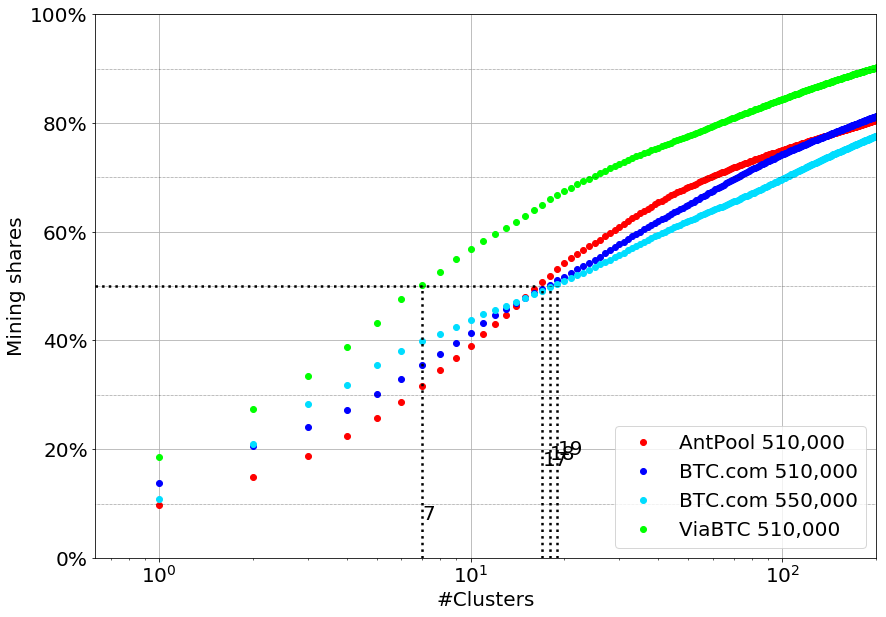

In [118]:
plt.figure(figsize=(14,10))
lw = 4
ls = 'o'
n_clusters_line = 100
xl = .5
yl = .5
fs = 20
c1 = 'black'
c2 = 'black'
lwl = 2.5

a = np.r_[0, antpool_shares.cumsum()]
b = np.r_[0, btccom_shares.cumsum()]
b2 = np.r_[0, btccom_shares2.cumsum()]
v = np.r_[0, viabtc_shares.cumsum()]

plt.semilogx(a, ls, label='AntPool 510,000', color='#FF0000', linewidth=lw)
plt.semilogx(b, ls, label='BTC.com 510,000', color='#0000FF', linewidth=lw)
plt.semilogx(b2, ls, label='BTC.com 550,000', color='#00DDFF', linewidth=lw)
plt.semilogx(v, ls, label='ViaBTC 510,000', color='#00FF00', linewidth=lw)
plt.grid(True)
plt.legend(loc=4, fontsize=fs)
ax = plt.gca()
## additional horizontal grid
ycoords = [i*10 for i in range(1,10) if i%2]
for yc in ycoords:
    plt.axhline(y=yc, color='#000000', linewidth=.5, linestyle=':')

plt.axvline(x=np.argmax(b>50), ymax=yl, color=c2, linestyle=':', linewidth=lwl)
ax.text(np.argmax(b>50), np.argmax(b>50), str(np.argmax(b>50)), rotation=0, color='black', fontsize=fs)

plt.axvline(x=np.argmax(b2>50), ymax=yl, color=c2, linestyle=':', linewidth=lwl)
ax.text(np.argmax(b2>50), np.argmax(b2>50), str(np.argmax(b2>50)), rotation=0, color='black', fontsize=fs)

plt.axvline(x=np.argmax(a>50), ymax=yl, color=c2, linestyle=':', linewidth=lwl)
ax.text(np.argmax(a>50), np.argmax(a>50), str(np.argmax(a>50)), rotation=0, color='black', fontsize=fs)

plt.axvline(x=np.argmax(v>50), ymax=yl, color=c2, linestyle=':', linewidth=lwl)
ax.text(np.argmax(v>50), np.argmax(v>50), str(np.argmax(v>50)), rotation=0, color='black', fontsize=fs)

plt.axhline(y=50, xmax=.569, color=c2, linestyle=':', linewidth=lwl)

vals = ax.get_yticks()
ax.set_yticklabels([str(int(x))+'%' for x in vals[1:]])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)
plt.xlabel('#Clusters', fontsize=fs)
plt.ylabel('Mining shares', fontsize=fs)
plt.savefig('./images/pool_centralization.pdf')
plt.show()

# Table 4

In [140]:
## Common addresses and BTC received

### AntPool, BTC.com
different from paper

In [119]:
antpool_btccom_df = antpool_df.merge(btccom_df, on='address')[['address', 'tag_x','AntPool_BTC_address', 'BTC.com_BTC_address']]
print('#Addresses in common', antpool_btccom_df.shape[0])
print('In percentage', 100*antpool_btccom_df.shape[0] / (btccom_df.shape[0] + antpool_df.shape[0] - antpool_btccom_df.shape[0]))
print('BTC received from AntPool', antpool_btccom_df['AntPool_BTC_address'].sum())
print('BTC received from BTC.com', antpool_btccom_df['BTC.com_BTC_address'].sum())

#Addresses in common 336
In percentage 1.1403746945424926
BTC received from AntPool 90.2037049
BTC received from BTC.com 399.78220131999996


### BTC.com, ViaBTC
different from paper

In [120]:
btccom_viabtc_df = btccom_df.merge(viabtc_df, on='address')[['address', 'tag_x','ViaBTC_BTC_address', 'BTC.com_BTC_address']]
print('#Addresses in common', btccom_viabtc_df.shape[0])
print('In percentage', 100*btccom_viabtc_df.shape[0] / (btccom_df.shape[0] + viabtc_df.shape[0] - btccom_viabtc_df.shape[0]))
print('BTC received from ViaBTC', btccom_viabtc_df['ViaBTC_BTC_address'].sum())
print('BTC received from BTC.com', btccom_viabtc_df['BTC.com_BTC_address'].sum())

#Addresses in common 250
In percentage 0.9136425099587033
BTC received from ViaBTC 174.09286704
BTC received from BTC.com 175.38987332


### AntPool, ViaBTC
different from paper

In [121]:
viabtc_antpool_df = antpool_df.merge(viabtc_df, on='address')[['address', 'tag_x','AntPool_BTC_address', 'ViaBTC_BTC_address']]
print('#Addresses in common', viabtc_antpool_df.shape[0])
print('In percentage', 100*viabtc_antpool_df.shape[0] / (viabtc_df.shape[0] + antpool_df.shape[0] - viabtc_antpool_df.shape[0]))
print('BTC received from AntPool', viabtc_antpool_df['AntPool_BTC_address'].sum())
print('BTC received from ViaBTC', viabtc_antpool_df['ViaBTC_BTC_address'].sum())

#Addresses in common 66
In percentage 0.4008989856040819
BTC received from AntPool 5.042241899999999
BTC received from ViaBTC 59.56508617


In [122]:
common_addresses_df = btccom_viabtc_df.merge(antpool_df, on='address')

In [123]:
## NOT in the paper
# ## for each common address find the sums received by mining for each pool
# common_addresses_BTC_df = common_addresses_df[['address', 'tag', 'ViaBTC_BTC_address', 'AntPool_BTC_address', 'BTC.com_BTC_address']]
# common_addresses_BTC_df = common_addresses_BTC_df.assign(total_BTC=common_addresses_df[['ViaBTC_BTC_address', 'AntPool_BTC_address', 'BTC.com_BTC_address']].sum(axis=1))
# common_addresses_BTC_df.sort_values('total_BTC', ascending=False)

### Common clusters

In [124]:
clusters_antpool_btccom_df = clusters_btccom_df.merge(clusters_antpool_df, on='cluster')
clusters_viabtc_antpool_df = clusters_viabtc_df.merge(clusters_antpool_df, on='cluster')
clusters_antpool_viabtc_df = clusters_antpool_df.merge(clusters_viabtc_df, on='cluster')
clusters_viabtc_btccom_df = clusters_btccom_df.merge(clusters_viabtc_df, on='cluster')

#### Antpool BTC.com

In [125]:
clusters_antpool_btccom_df.shape[0]

300

In [126]:
100*clusters_antpool_btccom_df.shape[0]/clusters_btccom_df.shape[0]

2.9753049687592976

In [127]:
100*clusters_antpool_btccom_df.shape[0]/clusters_antpool_df.shape[0]

5.2255704581083435

#### Antpool ViaBTC

In [128]:
clusters_viabtc_antpool_df.shape[0]

144

In [129]:
100*clusters_viabtc_antpool_df.shape[0]/clusters_antpool_df.shape[0]

2.508273819892005

In [130]:
100*clusters_viabtc_antpool_df.shape[0]/clusters_viabtc_df.shape[0]

4.861580013504389

#### ViaBTC BTC.com

In [131]:
clusters_viabtc_btccom_df.shape[0]

248

In [132]:
100*clusters_viabtc_btccom_df.shape[0]/clusters_viabtc_df.shape[0]

8.37272113436867

In [133]:
100*clusters_viabtc_btccom_df.shape[0]/clusters_btccom_df.shape[0]

2.4595854408410194

# Table 5 and 6

In [134]:
common_clusters_df = clusters_antpool_btccom_df.merge(clusters_viabtc_df, on='cluster')

7pool is part of the Bixin cluster

In [135]:
common_clusters_df.drop('tag_x', axis=1).drop('tag_y', axis=1).head(20)

,cluster,BTC.com_BTC_cluster,BTC.com_cluster_perc,BTC.com_tag_perc,n_cluster_addresses_x,AntPool_BTC_cluster,AntPool_cluster_perc,AntPool_tag_perc,n_cluster_addresses_y,ViaBTC_BTC_cluster,tag,ViaBTC_cluster_perc,ViaBTC_tag_perc,n_cluster_addresses
0,254056608,1660.485315,13.772194,13.772194,1033,104.662388,9.738295,9.738295,262,795.363449,7pool,18.570658,18.570658,476
1,490003380,826.718632,6.856869,6.856869,1238,54.986207,5.116183,5.116183,386,229.569256,Huobi.com-2,5.360131,5.360131,382
2,370914574,408.696791,3.389763,73.637806,875,39.830458,3.706019,76.143478,160,258.549301,None,6.036776,68.861875,347
3,312312041,293.547480,2.434706,73.637806,695,31.340640,2.916085,76.143478,216,189.415312,None,4.422591,68.861875,347
4,338682932,243.981902,2.023605,73.637806,31,1.192737,0.110978,76.143478,15,182.922926,None,4.271002,68.861875,23
5,270721914,242.453807,2.010931,73.637806,379,23.526625,2.189031,76.143478,184,46.302109,None,1.081091,68.861875,135
6,476058220,174.041777,1.443516,73.637806,233,13.113235,1.220119,76.143478,81,55.734548,None,1.301326,68.861875,94
7,367666133,152.467495,1.264577,2.088784,428,16.432331,1.528944,2.633945,234,83.599075,CKPool_cb,1.951925,2.961630,170
8,471618839,100.623495,0.834579,0.834579,880,6.737512,0.626891,0.626891,364,58.998591,CKPool_KnCMiner_Solo CKPool_un,1.377537,1.377537,178
9,486974716,79.317151,0.657863,0.657863,277,12.370918,1.151050,1.151050,97,43.361521,Bittrex.com,1.012433,1.012433,177


In [136]:
unknown_common_clusters_df = common_clusters_df.loc[(common_clusters_df.tag.str.contains('_')) | (common_clusters_df.tag == 'None')].drop(['tag', 'tag_x', 'tag_y'], axis=1) 
unknown_common_clusters_df = unknown_common_clusters_df.assign(total_BTC=unknown_common_clusters_df[['ViaBTC_BTC_cluster', 'AntPool_BTC_cluster', 'BTC.com_BTC_cluster']].sum(axis=1))
unknown_common_clusters_df.sort_values('total_BTC', ascending=False).head(50).round(2).head(20)

,cluster,BTC.com_BTC_cluster,BTC.com_cluster_perc,BTC.com_tag_perc,n_cluster_addresses_x,AntPool_BTC_cluster,AntPool_cluster_perc,AntPool_tag_perc,n_cluster_addresses_y,ViaBTC_BTC_cluster,ViaBTC_cluster_perc,ViaBTC_tag_perc,n_cluster_addresses,total_BTC
2,370914574,408.70,3.39,73.64,875,39.83,3.71,76.14,160,258.55,6.04,68.86,347,707.08
3,312312041,293.55,2.43,73.64,695,31.34,2.92,76.14,216,189.42,4.42,68.86,347,514.30
4,338682932,243.98,2.02,73.64,31,1.19,0.11,76.14,15,182.92,4.27,68.86,23,428.10
5,270721914,242.45,2.01,73.64,379,23.53,2.19,76.14,184,46.30,1.08,68.86,135,312.28
7,367666133,152.47,1.26,2.09,428,16.43,1.53,2.63,234,83.60,1.95,2.96,170,252.50
6,476058220,174.04,1.44,73.64,233,13.11,1.22,76.14,81,55.73,1.30,68.86,94,242.89
8,471618839,100.62,0.83,0.83,880,6.74,0.63,0.63,364,59.00,1.38,1.38,178,166.36
20,392442828,15.48,0.13,73.64,26,0.18,0.02,76.14,1,107.23,2.50,68.86,19,122.89
10,415658663,52.34,0.43,2.09,248,4.64,0.43,2.63,73,22.27,0.52,2.96,100,79.25
19,309322702,15.71,0.13,73.64,43,1.24,0.12,76.14,17,28.43,0.66,68.86,24,45.38


# Figure 5

In [137]:
mined_BTC_dict = {'AntPool': 7887.125947200003,
 'BTC.com': 13058.689395100004,
 'ViaBTC': 5840.928190009999}

In [138]:
def get_better_tag(tag):
    if tag == 'None':
        return 'Unknown'
    if len(tag.split('_')) > 1:
        return "Old Mining\nClusters"
#         return 'Old mining cluster (' + tag.split('_')[0] + ')'
    if 'Huobi' in tag.split('.'):
        return 'Huobi.com'
    if 'OKCoin' in tag.split('.'):
        return 'OkCoin.com'
    if '7pool' == tag:
        return 'Bixin'
    return tag

def expand(v):
    e = .11
    
    if v > 0:
        v += e
    else:
        v -= e
    return v

def tag2color(tag):
    if tag == btccom_tag:
        return 'blue'
    if tag == antpool_tag:
        return 'red'
    if tag == viabtc_tag:
        return 'green'
    if tag == 'Unknown' or 'Old' in tag.split(' '):
        return 'grey'
    return 'black'


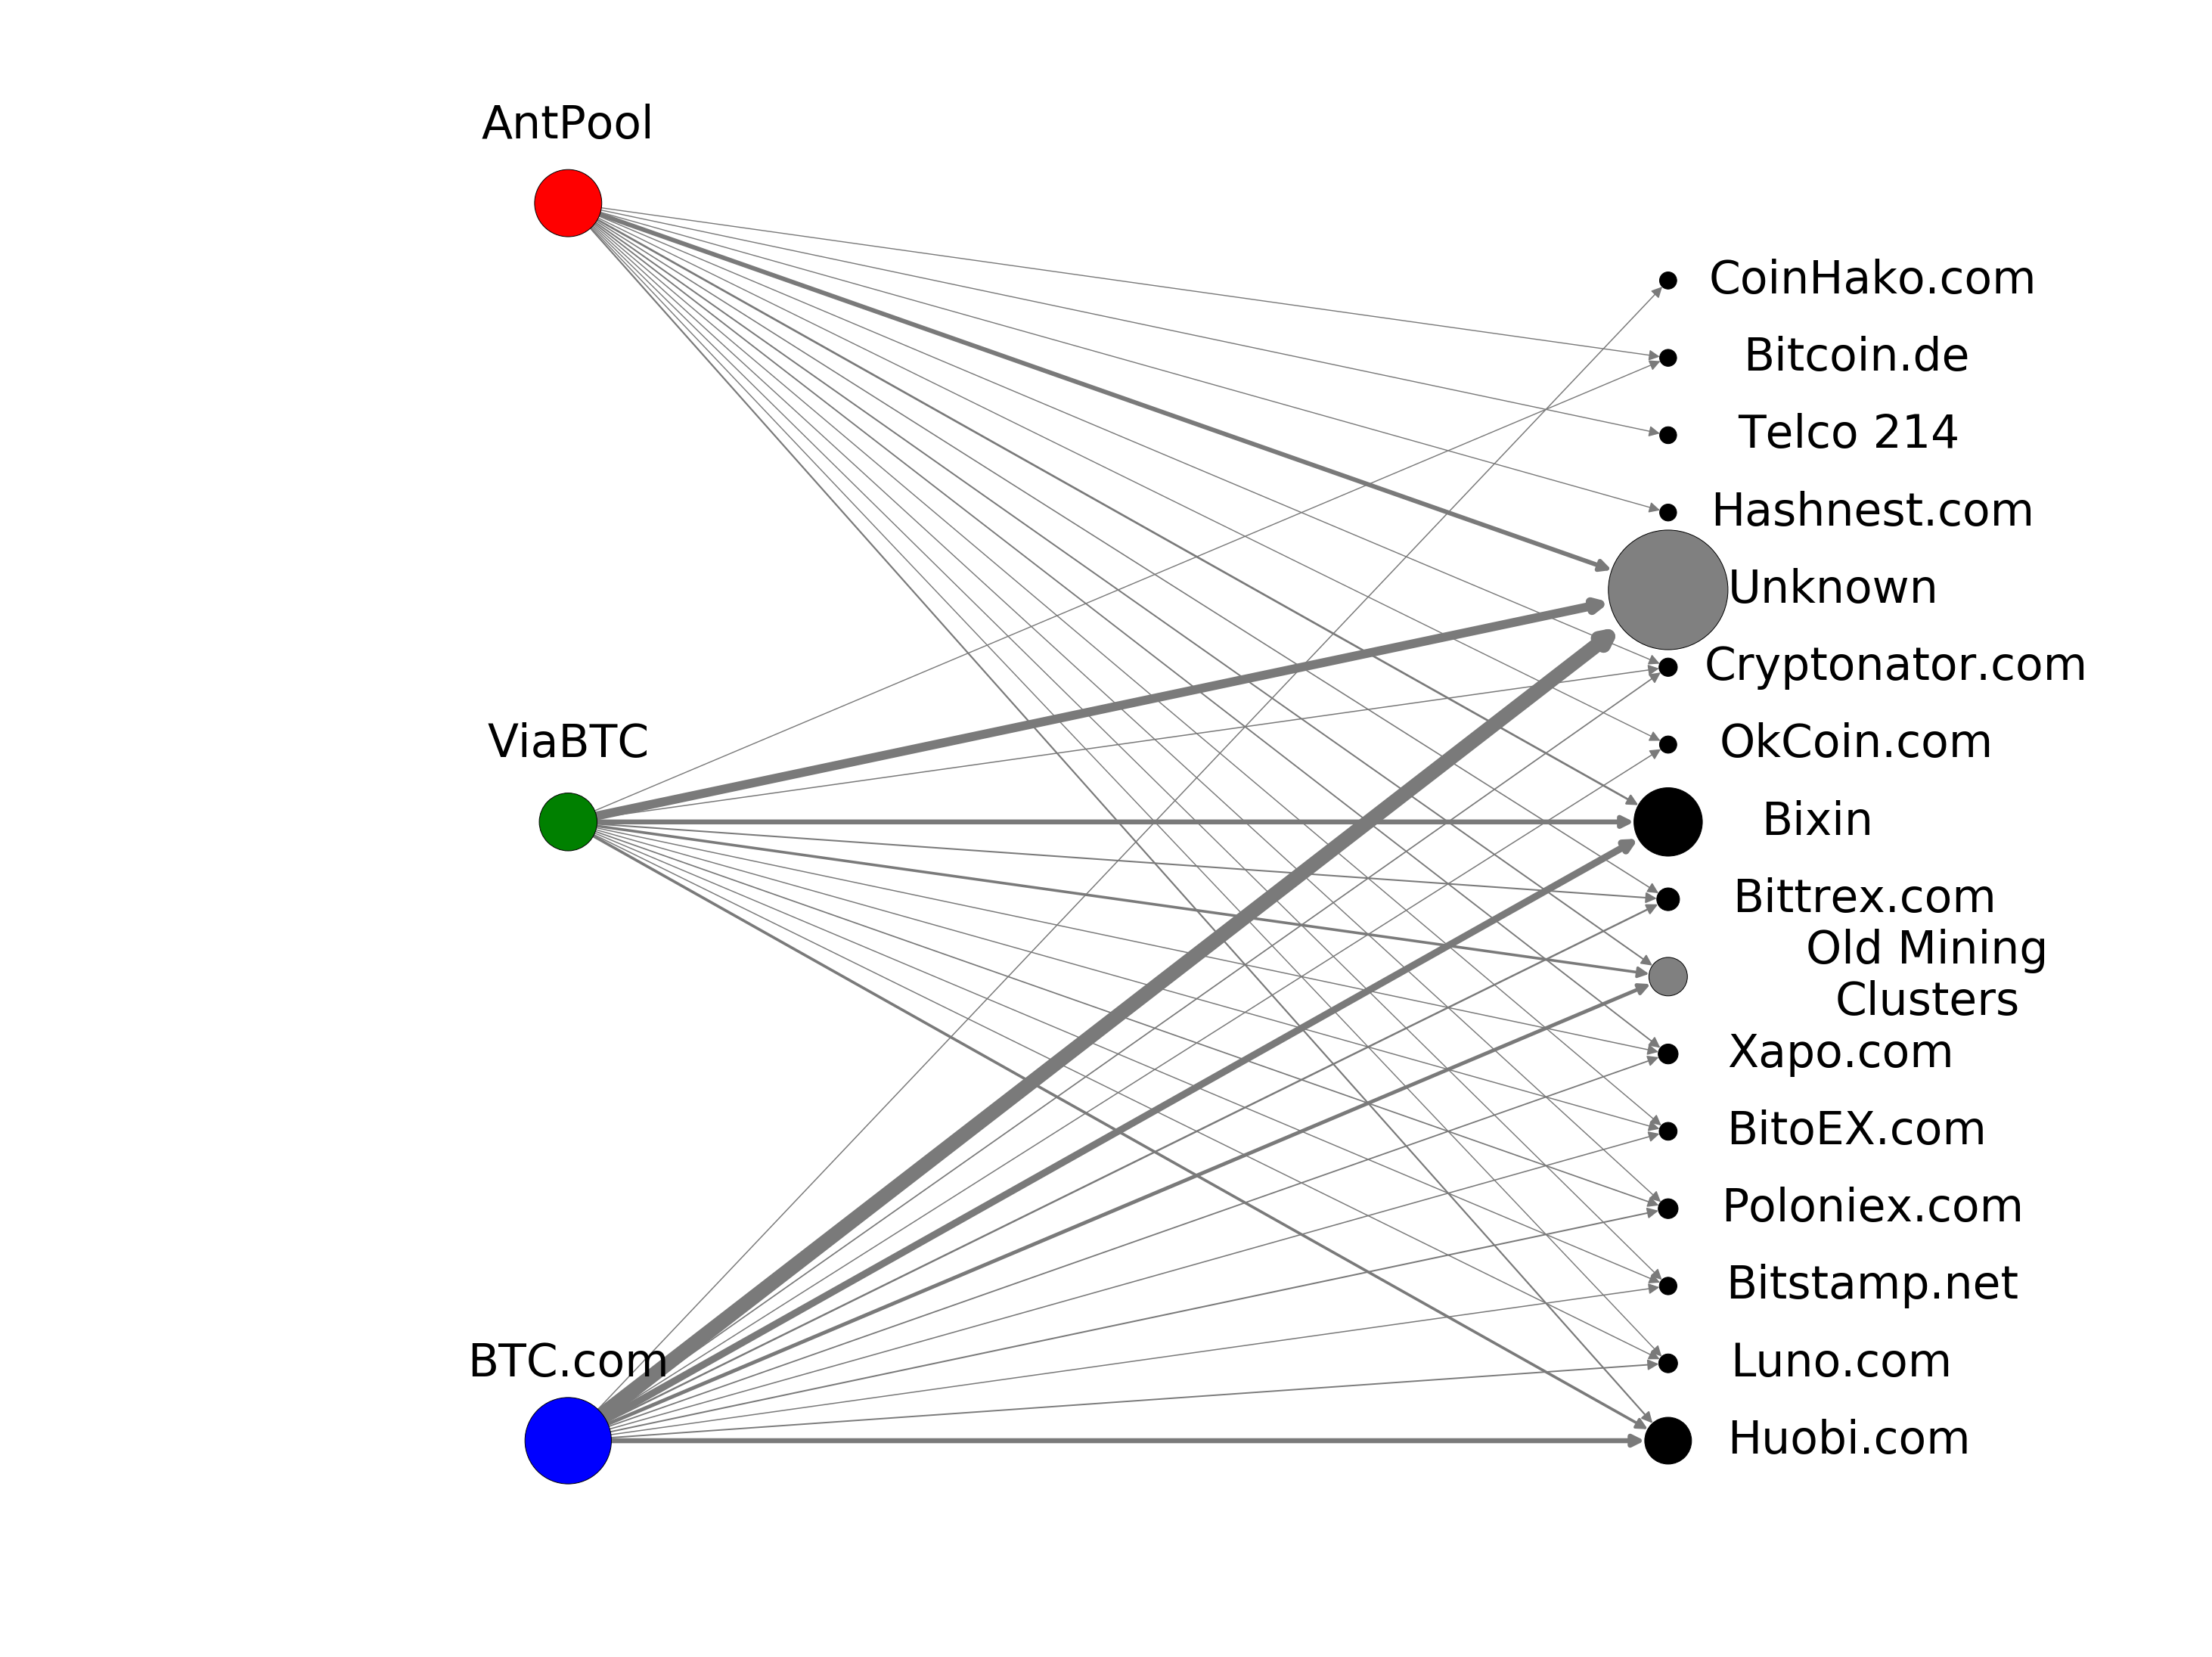

In [139]:
# for each pool, select the top n clusters and put them in the graph
# label is the tag of the cluster
# size is the n of addresses in cluster
# color is the type of service of the tag
# edge thickness between nodes is the amount of money exchanged 
g = nx.DiGraph()

n_clusters = 400 # number of clusters from each pool to show in the graph
btccom_cID = 1
antpool_cID = 2
viabtc_cID = 3
edge_thick_factor = .05
node_size_factor = 3
min_node_size = 500
min_edge_size = 2
pool_size = 3000
tag_BTC = dict()
btccom_tag = 'BTC.com'
antpool_tag = 'AntPool'
viabtc_tag = 'ViaBTC'


# pools nodes
g.add_node(btccom_tag, text='BTC.com', size=mined_BTC_dict[btccom_tag], bipartite=0)
g.add_node(antpool_tag, text='AntPool', size=mined_BTC_dict[antpool_tag], bipartite=0)
g.add_node(viabtc_tag, text='ViaBTC', size=mined_BTC_dict[viabtc_tag], bipartite=0)
# g.add_node(btccom_tag, text='BTC.com', size=pool_size*node_size_factor)
# g.add_node(antpool_tag, text='AntPool', size=pool_size*node_size_factor)
# g.add_node(viabtc_tag, text='ViaBTC', size=pool_size*node_size_factor)

edge_color = '#7a7a7a'

n_unknown_clusters = 0
n_old_mining_clusters = 0
# antpool members
weights = dict()
for cID,tag,btc,n_addr in zip(clusters_antpool_df.head(n_clusters)['cluster'].values,\
        clusters_antpool_df.head(n_clusters)['tag'].values,\
        clusters_antpool_df.head(n_clusters)['AntPool_BTC_cluster'].values,\
        clusters_antpool_df.head(n_clusters)['n_cluster_addresses'].values):
    tag = get_better_tag(tag)
    if tag == 'Unknown':
        n_unknown_clusters += 1
    elif 'Old' in tag.split(' '):
        n_old_mining_clusters += 1
    if tag not in tag_BTC.keys():
        tag_BTC[tag] = 0
    tag_BTC[tag] += btc
    g.add_node(tag, text=tag, size=tag_BTC[tag]*node_size_factor + min_node_size, bipartite=1)
    w = btc*edge_thick_factor
    tp = tag + antpool_tag
    if tp not in weights.keys():
        weights[tp] = 0
    weights[tp] += w
    g.add_edge(antpool_tag, tag, weight=weights[tp] + min_edge_size, color=edge_color)

# # viabtc members
for cID,tag,btc,n_addr in zip(clusters_viabtc_df.head(n_clusters)['cluster'].values,\
        clusters_viabtc_df.head(n_clusters)['tag'].values,\
        clusters_viabtc_df.head(n_clusters)['ViaBTC_BTC_cluster'].values,\
        clusters_viabtc_df.head(n_clusters)['n_cluster_addresses'].values):
    tag = get_better_tag(tag)
    if tag == 'Unknown':
        n_unknown_clusters += 1
    elif 'Old' in tag.split(' '):
        n_old_mining_clusters += 1
    if tag not in tag_BTC.keys():
        tag_BTC[tag] = 0
    tag_BTC[tag] += btc
    g.add_node(tag, text=tag, size=tag_BTC[tag]*node_size_factor + min_node_size, bipartite=1)
    w = btc*edge_thick_factor
    tp = tag + viabtc_tag
    if tp not in weights.keys():
        weights[tp] = 0
    weights[tp] += w
    g.add_edge(viabtc_tag, tag, weight=weights[tp] + min_edge_size, color=edge_color)

# btccom members
for cID,tag,btc,n_addr in zip(clusters_btccom_df.head(n_clusters)['cluster'].values,\
        clusters_btccom_df.head(n_clusters)['tag'].values,\
        clusters_btccom_df.head(n_clusters)['BTC.com_BTC_cluster'].values,\
        clusters_btccom_df.head(n_clusters)['n_cluster_addresses'].values):
    tag = get_better_tag(tag)
    if tag == 'Unknown':
        n_unknown_clusters += 1
    elif 'Old' in tag.split(' '):
        n_old_mining_clusters += 1
    if tag not in tag_BTC.keys():
        tag_BTC[tag] = 0
    tag_BTC[tag] += btc
    g.add_node(tag, text=tag, size=tag_BTC[tag]*node_size_factor + min_node_size, bipartite=1)
    w = btc*edge_thick_factor
    tp = tag + btccom_tag
    if tp not in weights.keys():
        weights[tp] = 0
    weights[tp] += w
    g.add_edge(btccom_tag, tag, weight=weights[tp] + min_edge_size, color=edge_color)

node_color = []
node_size = []
size_dict = nx.get_node_attributes(g,'size')
for node in g:
#     print(node)
    # get size
    node_size.append(min(25000, size_dict[node]))
#     node_size.append(min(15000, size_dict[node]))
    # get color
    node_color.append(tag2color(node))
edges = g.edges()
weights = [g[u][v]['weight']**(1/2) for u,v in edges]
ecolors = [g[u][v]['color'] for u,v in edges]

fig_factor = 10

plt.figure(figsize=(fig_factor*4,fig_factor*3))
# plt.figure(figsize=(10,8))
# pos = nx.circular_layout(g) # good
pos = nx.shell_layout(g) # good
# pos = nx.spring_layout(g) # meh
# pos = nx.spectral_layout(g) bad
# pos = nx.fruchterman_reingold_layout(g) # ok

pos_higher = {}
for k, v in pos.items():
    if k == 'Bitcoin.de':
#         print(k)
        x = expand(v[0])
        y = expand(v[1]) - 0.04
    elif k == 'Unknown':
        x = expand(v[0]) - 0.2
        y = expand(v[1]) 
    elif k in ['Huobi.com', 'BitoEX.com']:
        x = expand(v[0]) - 0.1
        y = expand(v[1]) 
    elif 'br' in k.split('.') or 'Old' in k.split(' ') or 'Hashnest.com' == k:
        x = expand(v[0]) + 0.1
        y = expand(v[1]) 
    elif 'br' in k.split('.'):
        x = expand(v[0]) + 0.1
        y = expand(v[1]) - 0.02
    elif 'CoinSpot' in k.split('.'):
        x = expand(v[0]) - 0.1
        y = expand(v[1]) 
    elif 'BTC.com' == k:
        x = expand(v[0]) + 0.12
        y = expand(v[1]) + .2
    elif 'Cryptonator.com' == k:
        x = expand(v[0]) + 0.21
        y = expand(v[1]) 
    else:
        x = expand(v[0])
        y = expand(v[1])
    pos_higher[k] = (x, y)
# print(node_size)

X, Y = bipartite.sets(g)
pos = dict()
pos_label = dict()
pos.update( (n, (0, i*8)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2

pos_label.update( (n, (0, 1 + i*8)) for i, n in enumerate(X) ) # put nodes from X 
pos_label.update( (n, (2+.5 - (len('MercadoBitcoin.com.br') - len(n))/70, i)) for i, n in enumerate(Y) ) # put nodes from Y 

# nx.draw(g, with_labels=True, labels=labels, node_color=color_map, layout=nx.shell_layout(G, scale=2), font_size=12)

nx.draw(g, pos, arrows=True, arrowsize=30, edge_color=ecolors, node_color=node_color, width=weights, node_size=node_size)
nx.draw_networkx_labels(g, pos_label, labels=nx.get_node_attributes(g,'text'), font_size=60)

# nx.draw(g, pos, arrows=True, arrowsize=30, node_color=node_color, width=weights, node_size=node_size)
# nx.draw_networkx_labels(g, pos_higher, labels=nx.get_node_attributes(g,'text'), font_size=80)
ax= plt.gca()
ax.collections[0].set_edgecolor('#000000')
ax.margins(.4, .1)
title = 'images/payments_graph_' + str(n_clusters) + '.pdf'
plt.savefig(title)
plt.show()